Nolan Roth <br>
PHYS 434

# Lab #4

In [201]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy import stats
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (15,10)

In [202]:
hf = h5py.File('gammaray_lab4.h5', 'r')

In [203]:
hf.keys()

<KeysViewHDF5 ['data']>

In [204]:
data = np.array(hf.get('data'))

In [205]:
data[:,0]

array([9.40680016e+08, 3.15000000e+02, 4.50000000e+01, 1.00000000e+01])

In [206]:
hf.close()

## Problem 1

We are given a dataset of the number of particles detected by a satellite every 100 milliseconds. Each data point is paired with the metadata of time, solar phase, and longitude at which the data reading was taken.

How the solar phase varies with time:

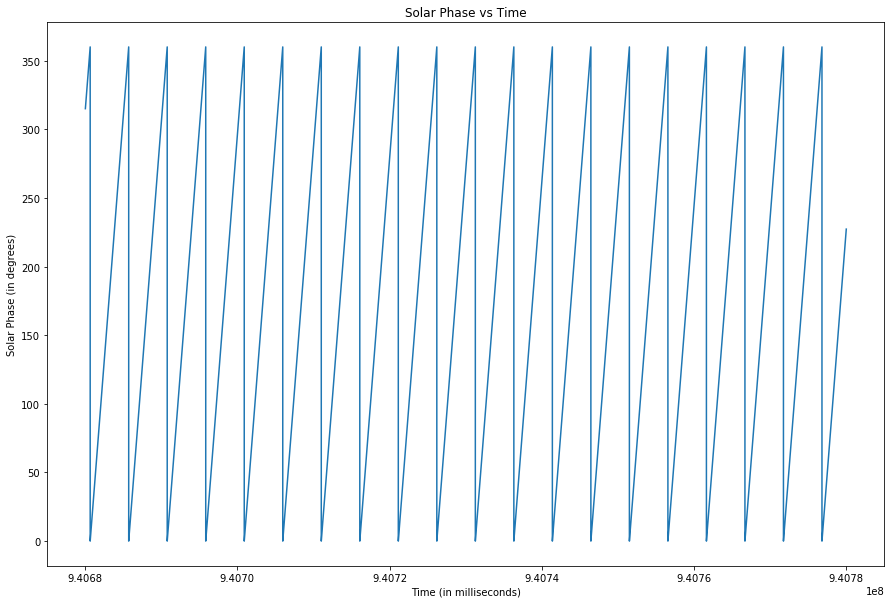

In [207]:
x = data[0, 0:1000000]
y = data[1, 0:1000000]
plt.plot(x, y)
plt.xlabel('Time (in milliseconds)')
plt.ylabel('Solar Phase (in degrees)')
plt.title('Solar Phase vs Time')
plt.show()

How the longitude varies with time:

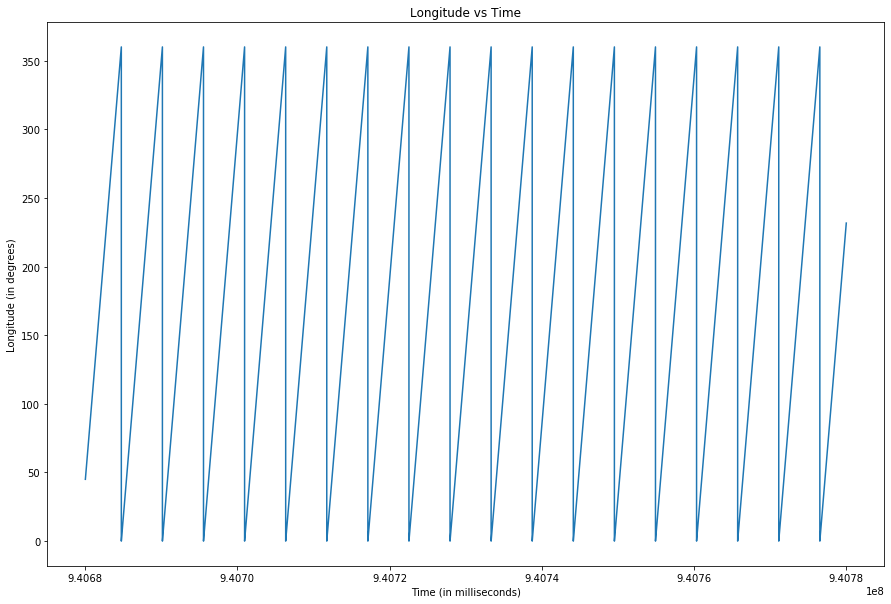

In [208]:
x = data[0, 0:1000000]
y = data[2, 0:1000000]
plt.plot(x, y)
plt.title('Longitude vs Time')
plt.ylabel('Longitude (in degrees)')
plt.xlabel('Time (in milliseconds)')
plt.show()

How the particle count varies with time:

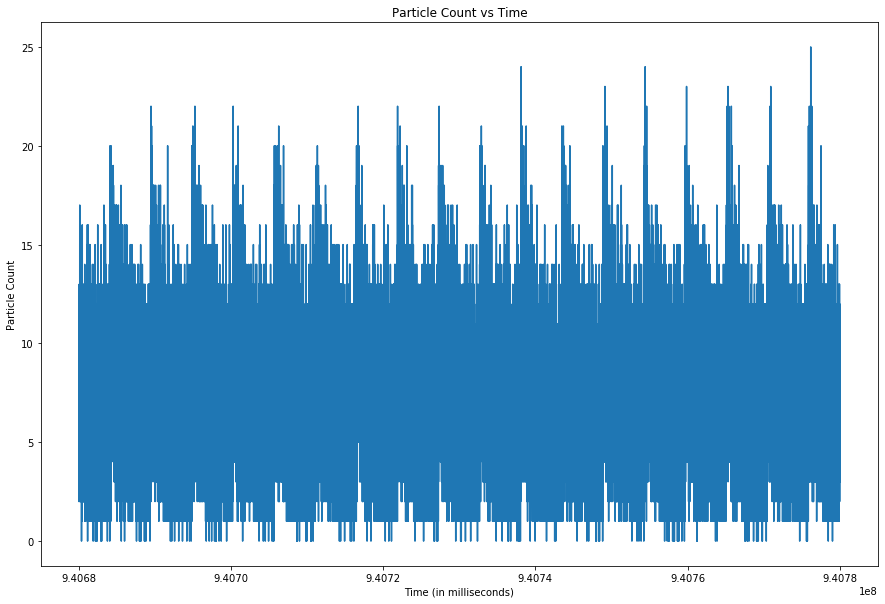

In [209]:
x = data[0, 0:1000000:10]
y = data[3, 0:1000000:10]
plt.plot(x, y)
plt.title('Particle Count vs Time')
plt.xlabel('Time (in milliseconds)')
plt.ylabel('Particle Count')
plt.show()

We can see from the plot of particle count versus time that the background is not consistent across the dataset. The mean particle count of the background seems to increase and decrease periodically.

Seeing how the particle count varies with solar phase and longitude:

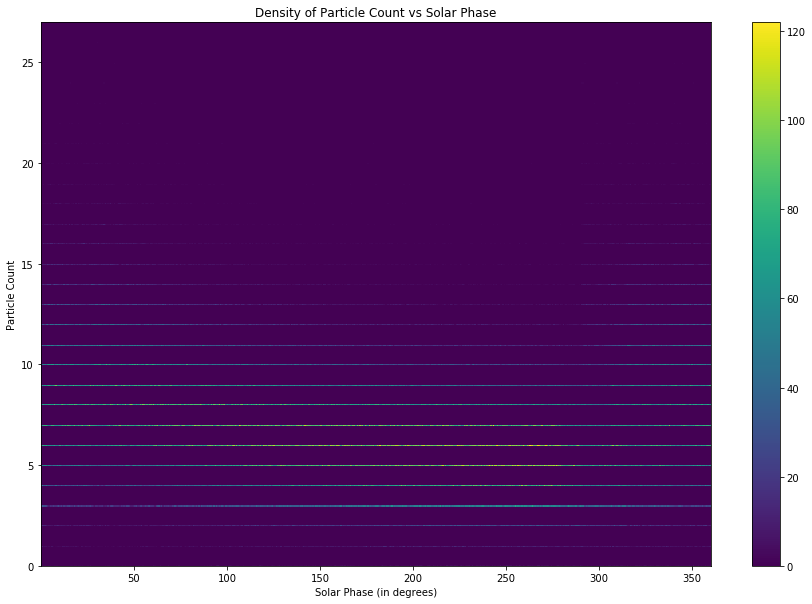

In [212]:
x = data[1, 100000:400000]
y = data[3, 100000:400000]
plt.hist2d(x, y, 500)
plt.title('Density of Particle Count vs Solar Phase')
plt.ylabel('Particle Count')
plt.xlabel('Solar Phase (in degrees)')
plt.colorbar()
plt.show()

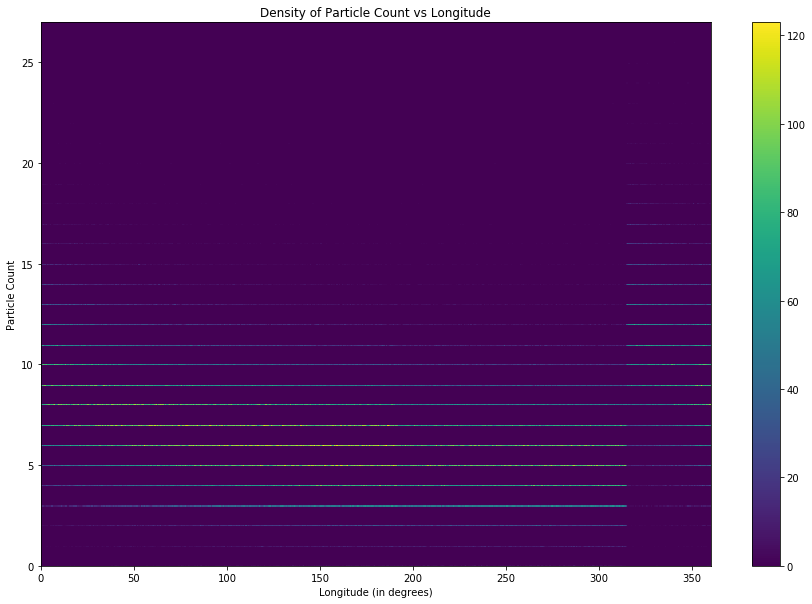

In [213]:
x = data[2, 100000:400000]
y = data[3, 100000:400000]
plt.hist2d(x, y, 500)
plt.title('Density of Particle Count vs Longitude')
plt.xlabel('Longitude (in degrees)')
plt.ylabel('Particle Count')
plt.colorbar()
plt.show()

We can see that the mean particle count makes a jump from around 6 to around 9 somewhere between 300 and 350 degrees longitude.

The background is a Poisson distribution, so I can create a Poisson distribution with a mean that varies according to how the mean of our background varies with longitude to more accurately describe the background.

In order to see how the distribution changes with respect to the longitude, I take the mean of the particle count at each value of the longitude. Then I plot the means versus longitude:

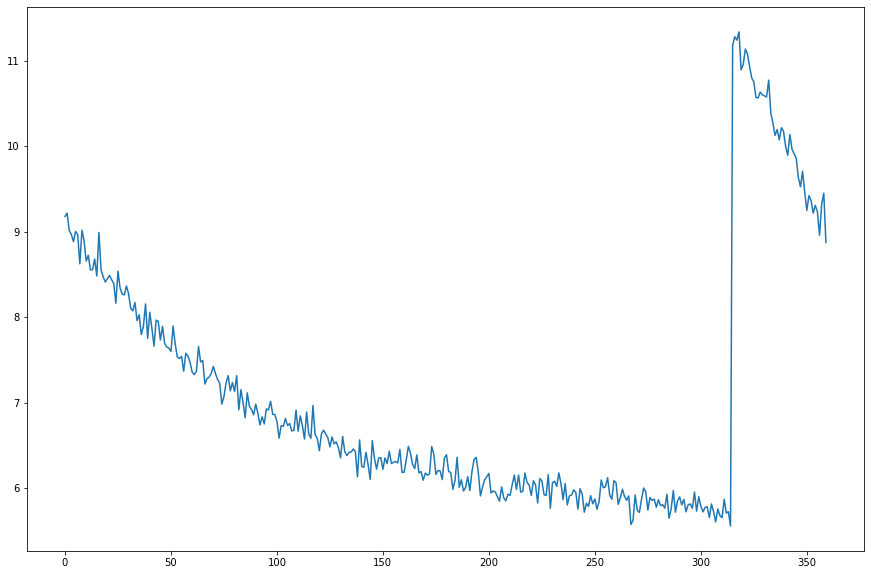

In [15]:
counts = data[3]
longs = np.arange(360)
means = []
for i in longs:
    mean = np.mean(counts[data[2]==i])
    means.append(mean)
plt.plot(longs, means)
plt.show()

In [16]:
print('Mean at longitude of 314 degrees: ' + str(means[314]))
print('Mean at longitude of 315 degrees: ' + str(means[315]))

Mean at longitude of 314 degrees: 5.55625
Mean at longitude of 315 degrees: 11.183333333333334


So there is a big jump in the mean from 5.6 particles to 11.2 particles in between 314 and 315 degrees.

So I want to create a time-dependent Poisson for our background that reflects the change in the mean at different longitudes.

My time dependent background distribution is a Poisson distribution with a mean equal to the mean particle count at the longitude of the time being examined.

In [226]:
def model_plot(time):
    for i in range(len(data[0])):
        if data[0, i] == time:
            long = data[2, i]
            print('Longitude: ' + str(long))
            break
    mean = means[int(long)]
    print('Mean at longitude: ' + str(mean))
    x = np.arange(0,20)
    plt.vlines(x, 0, stats.poisson.pmf(x, mean), colors='b', lw=40, alpha=0.5)
    plt.title('Piosson Distribution, mean = ' + str(mean))
    plt.xlabel('Particle Count')
    plt.xlim(0, 20)
    plt.ylabel('Probability')
    plt.show()

Comparing my model to the real data:

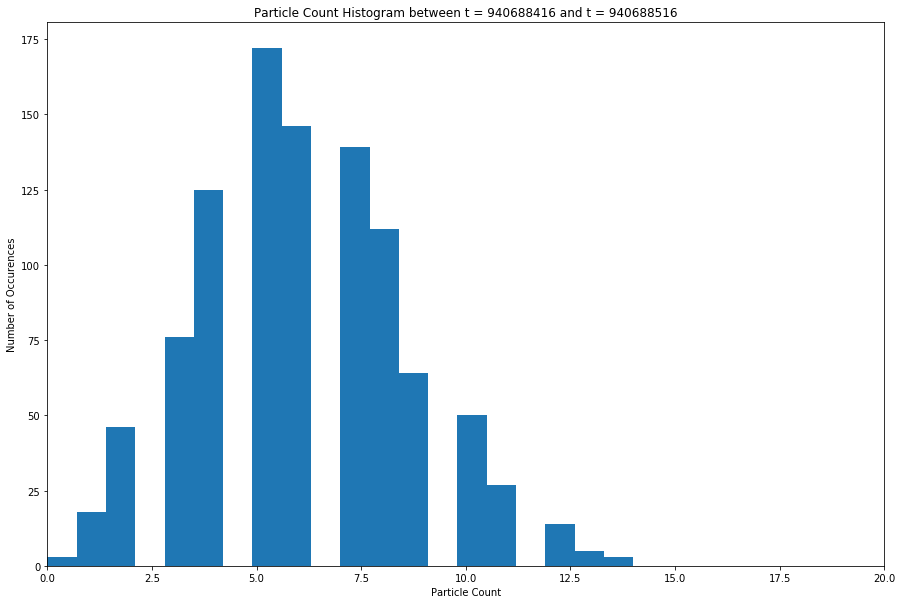

In [223]:
y = data[3,84000:85000]
plt.hist(y, 20)
plt.xlim(0, 20)
plt.title('Particle Count Histogram between t = 940688416 and t = 940688516')
plt.xlabel('Particle Count')
plt.ylabel('Number of Occurences')
plt.show()

Longitude: 251.66666666666663
Mean at longitude: 5.754166666666666


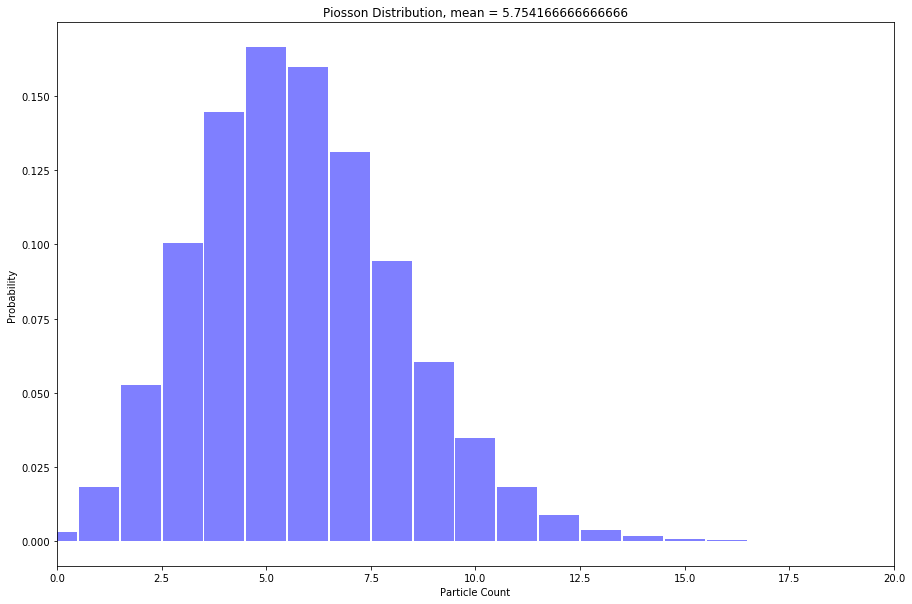

In [227]:
model_plot(data[0,85000])

Testing another point in time:

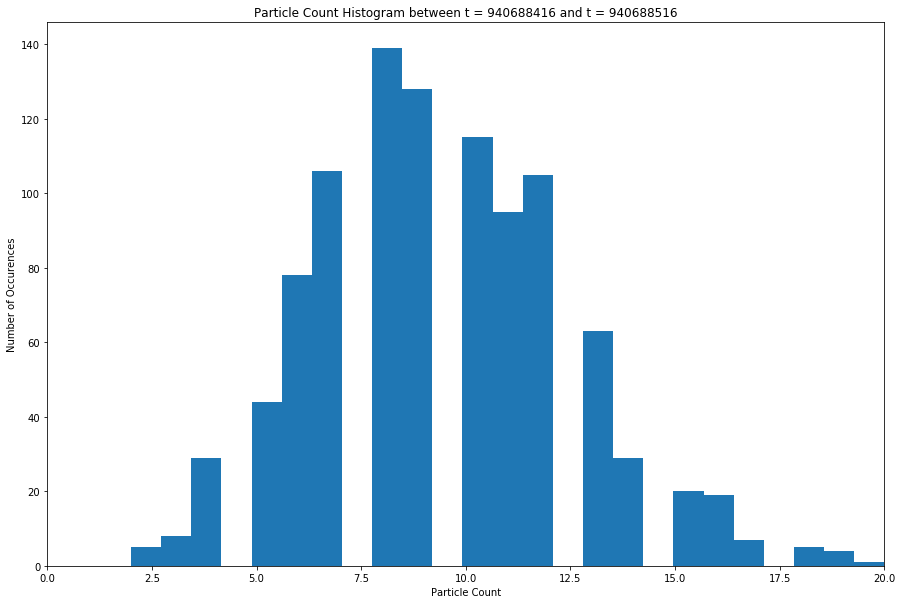

In [232]:
y = data[3,100000:101000]
plt.hist(y, 25)
plt.xlim(0, 20)
plt.title('Particle Count Histogram between t = 940688416 and t = 940688516')
plt.xlabel('Particle Count')
plt.ylabel('Number of Occurences')
plt.show()

Longitude: 358.33333333333337
Mean at longitude: 9.452083333333333


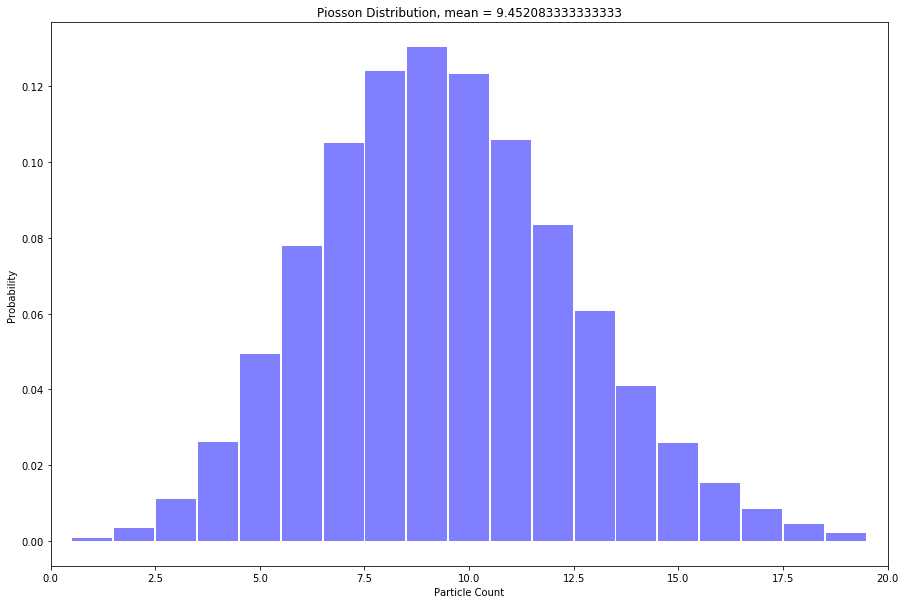

In [231]:
model_plot(data[0,101000])

It seems like this model approximates the distribution of particle counts fairly well.

Finding the 5$\sigma$ threshold at different times:

In [273]:
def model(time, threshold):
    for i in range(len(data[0])):
        if data[0, i] == time:
            long = data[2, i]
            break
    mean = means[int(long)]
    prob = 1 - stats.norm.cdf(threshold)
    threshold = stats.poisson.ppf(1 - prob, mean)
    print('Time: ' + str(time))
    print('Longitude: ' + str(long))
    print('Mean at longitude: ' + str(mean))
    print('Threshold for 5 sigma: ' + str(threshold))

In [276]:
model(data[0, 85000], 5)

Time: 940688516.0
Longitude: 251.66666666666663
Mean at longitude: 5.754166666666666
Threshold for 5 sigma: 21.0


In [275]:
model(data[0, 101000], 5)

Time: 940690116.0
Longitude: 358.33333333333337
Mean at longitude: 9.452083333333333
Threshold for 5 sigma: 28.0


In [279]:
model(data[0, 1500000], 5)

Time: 940830016.0
Longitude: 325.0
Mean at longitude: 10.754166666666666
Threshold for 5 sigma: 31.0


So the 5 $\sigma$ thresholds at times 940688516, 940690116, and 940830016 are 21, 28, and 31 particles respectively.

## Problem 2

In [281]:
hf = h5py.File('images.h5', 'r')

In [282]:
hf.keys()

<KeysViewHDF5 ['image1', 'imagestack']>

In [283]:
data = np.array(hf.get('imagestack'))

Testing the first image for spacial dependence:

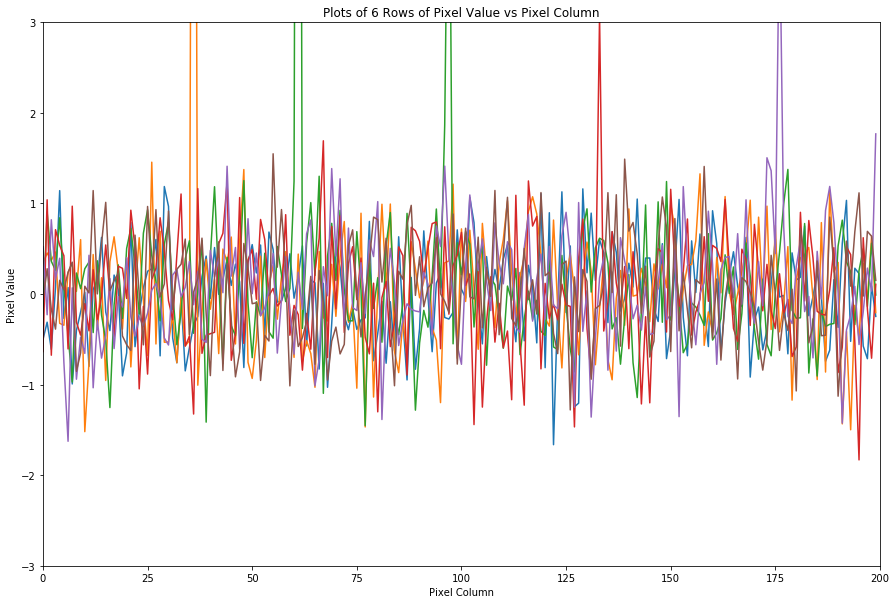

In [284]:
row = [0, 10, 50, 100, 120, 170]
for i in range(0, len(row)):
    col = data[row[i], :, 2]
    plt.plot(np.arange(200), col)
plt.ylim(-3, 3)
plt.xlim(0, 200)
plt.title('Plots of 6 Rows of Pixel Value vs Pixel Column')
plt.xlabel('Pixel Column')
plt.ylabel('Pixel Value')
plt.show()

We are not given time in the data, so we cannot tell whether the data is time dependent. We can tell from the plot above testing one image that there does not seem to be any distinguishable spacial dependence.

Compiling all the pixel values for the 10 images to find the distribution:

In [286]:
intensities =[]
for z in range(0, len(data[0, 0])):
    for i in range(0, len(data)):
        for j in range(0, len(data)):
            intensities.append(data[i, j, z])

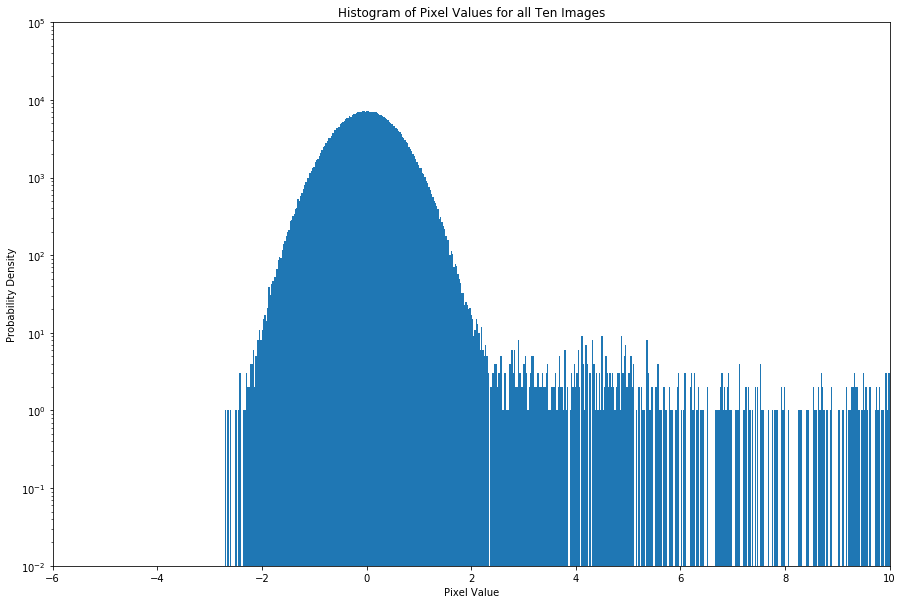

In [290]:
plt.hist(intensities, 2000)
x = np.linspace(-5, 5, 1000)
plt.xlim(-6, 10)
plt.ylim(10e-3, 100000)
plt.yscale('log')
plt.title('Histogram of Pixel Values for all Ten Images')
plt.xlabel('Pixel Value')
plt.ylabel('Probability Density')
plt.show()

The background appears to be a normal distribution.